# *Analysis of Regular Freight Cost*

[URL]:https://github.com/Kieranchian
[![Source Code](https://img.shields.io/badge/source_code-green?logo=github&labelColor=gray)][URL]
![release](https://badgen.net/github/release/epogrebnyak/ssg-dataset)


In [1]:
import time
import datetime
import sqlite3

import operator
import numpy as np
import scipy as sp
import pandas as pd
from this import d
from numpy import random
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
from bs4 import BeautifulSoup
from selenium import webdriver
from sklearn import linear_model

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


### *Scraping the gas price data from the website*

In [2]:
url = 'https://www.zuixinyoujia.com/guonei/'

In [3]:
def get_gas_prices(url):
    chrome_obj = webdriver.Chrome()
    try:
        chrome_obj.get(url)
        chrome_obj.implicitly_wait(10)
        return chrome_obj.page_source
    except SystemExit as e:
        print("Error:", str(e))
        return {'error': 'An error occurred while retrieving the data.'}
    finally:
        chrome_obj.close()
        
def parse_gas_prices():
    html = get_gas_prices(url)
    soup = BeautifulSoup(html, "html.parser")
    tables = soup.find_all('table')
    gas_price = pd.read_html(StringIO(str(tables[1])), header=0, flavor='bs4')[0]
    # 获取当前日期
    current_date = datetime.date.today()
    current_date_str = current_date.strftime('%Y-%m-%d')
    # 使用assign方法为每一列添加当前日期字段
    gas_price = gas_price.assign(日期=current_date_str)
    return {'data': gas_price.to_dict('records')}

In [4]:
data_list = parse_gas_prices()['data'] #获取油价数据list集合

### *Calculating the cost of regular freight*

In [5]:
class Route:
    def __init__(self, prov, mile, cbm):
        self.prov = prov
        self.mile = mile
        self.cbm = cbm
        
    @classmethod
    def calculation_standards(cls): # 定义计算标准
        conn = sqlite3.connect('cost.db')
        df =  pd.read_sql_query('select * from calculation_standards', conn)
        stda_list = df.to_dict('records')
        return stda_list
        
    def diesel_cost(self): # 定义燃料价格成本
        # data_list = parse_gas_prices()['data']
        for data in data_list:
            # 使用字典推导式获取值为'province'的键值对，并返回新的字典
            if any({key: value for key, value in data.items() if value == self.prov}):
                diesel_price = data.get('0号柴油')
                # 遍历油费计算标准，
                for stda in Route.calculation_standards():
                    if stda.get('cbm') == self.cbm:
                        return stda.get('fuel_consumption_standard')/100*diesel_price*self.mile
                
    def road_toll(self): # 定义路桥费
        conn = sqlite3.connect('cost.db')
        df = pd.read_sql_query('select * from road_toll', conn)
        rate_list = df.to_dict('records')
        for rate in rate_list:
            if any({key: value for key, value in rate.items() if value == self.prov}):
                return rate.get(str(self.cbm))*self.mile

    def salary(self): # 定义薪资
        conn = sqlite3.connect('cost.db')
        df = pd.read_sql_query('select * from salary', conn)
        sala_list = df.to_dict('records')
        for sala in sala_list:
            if sala.get('mile_min') < self.mile <= sala.get('mile_max'):
                return sala.get('salary')/30

    def insurance(self): # 定义保险
        for stda in Route.calculation_standards():
            if stda.get('cbm') == self.cbm:
                return stda.get('insurance')/360

    def maintenance_cost(self): # 定义维护成本（保养费用）
        for stda in Route.calculation_standards():
            if stda.get('cbm') == self.cbm:
                return stda.get('maintenance_cost')/10000*self.mile

    def tyre_cost(self): # 定义轮胎费用
        for stda in Route.calculation_standards():
            if stda.get('cbm') == self.cbm:
                return stda.get('tyre_cost')*stda.get('tyre_numb')/100000*self.mile

    def profit(self): # 定义利润
        conn = sqlite3.connect('cost.db')
        df = pd.read_sql_query('select * from salary', conn)
        sala_list = df.to_dict('records')
        for sala in sala_list:
            if sala.get('mile_min') < self.mile <= sala.get('mile_max'):
                #return sala.get('recovery_period')
                for stda in Route.calculation_standards():
                    if stda.get('cbm') == self.cbm:
                        return stda.get('truck_price')/sala.get('recovery_period')/30

def total_cost(prov, mile, cbm):
    route = Route(prov, mile, cbm)
    cost = [route.diesel_cost(),route.road_toll(),route.salary(),route.insurance(),
            route.maintenance_cost(),route.tyre_cost(),route.profit()]
    return [round(num, 2) for num in cost]
# 注：往返里程成本≠单边里程成本*2，比如保险是按年月，每日的保险费用不受里程远近影响

In [6]:
total_cost('重庆', 263, 45)

[428.16, 173.58, 156.67, 38.89, 15.78, 31.56, 215.28]

### *Obtain random data of the route for testing*

###### ①*自然社会当中的数据无非服从均匀分布、正态分布、偏态分布和峰态分布等*
###### ②*地区服从均匀分布、里程服从正态分布、*

In [7]:
def line_random_data(): 
    line_random_data = []
    random.seed(5)
    while operator.lt(len(line_random_data),1000):
        i = [random.choice([d['地区'] for d in data_list]),
             #lower, upper = mu - 3 * sigma, mu + 3 * sigma  # 截断在[μ-3σ, μ+3σ]
             #stats.truncnorm.rvs((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
             round(sp.stats.truncnorm.rvs((0.3 - 3) / 0.9, (5.7 - 3) / 0.9, loc=3, scale=0.9)*167),
             random.choice([12,16,20,30,35,45,56])
            ]
        line_random_data.append(i)
    return line_random_data

In [8]:
line_random_data()[0:3]

[['重庆', 263, 45], ['广东', 449, 16], ['贵州', 300, 56]]

### *Obtain cost random data for testing*

In [9]:
def cost_random_data():
    result = []
    for i in line_random_data():
        route = Route(i[0],i[1],i[2])
        cost_list = [route.diesel_cost(),route.road_toll(),route.salary(),
                     route.insurance(),route.maintenance_cost(),route.tyre_cost(),route.profit()]
        cost_form=i+[round(bb,2) for bb in cost_list]
        result.append(cost_form)
    return result

In [10]:
df = pd.DataFrame(
    cost_random_data(),
    columns=['prov','mile','cbm','di_co','ro_to','sala','insu','ma_co','ty_co','prof']
)
df['to_co'] = df['di_co']+df['ro_to']+df['sala']+df['insu']+df['ma_co']+df['ty_co']+df['prof']
df.head()

,prov,mile,cbm,di_co,ro_to,sala,insu,ma_co,ty_co,prof,to_co
0,重庆,263,45,428.16,173.58,156.67,38.89,15.78,31.56,215.28,1059.92
1,广东,449,16,461.39,107.76,183.33,19.44,22.45,18.86,98.48,911.71
2,贵州,300,56,557.25,324.00,156.67,47.22,24.00,52.80,354.86,1516.80
3,黑龙江,445,12,415.36,89.00,183.33,19.44,22.25,18.69,90.91,838.98
4,广西,848,16,877.34,203.52,208.33,19.44,42.40,35.62,120.37,1507.02


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   prov    1000 non-null   object 
 1   mile    1000 non-null   int64  
 2   cbm     1000 non-null   int32  
 3   di_co   1000 non-null   float64
 4   ro_to   1000 non-null   float64
 5   sala    1000 non-null   float64
 6   insu    1000 non-null   float64
 7   ma_co   1000 non-null   float64
 8   ty_co   1000 non-null   float64
 9   prof    1000 non-null   float64
 10  to_co   1000 non-null   float64
dtypes: float64(8), int32(1), int64(1), object(1)
memory usage: 82.2+ KB


### *Normal distribution test*

Kurtosis: -0.190341
Skewness: 0.070603


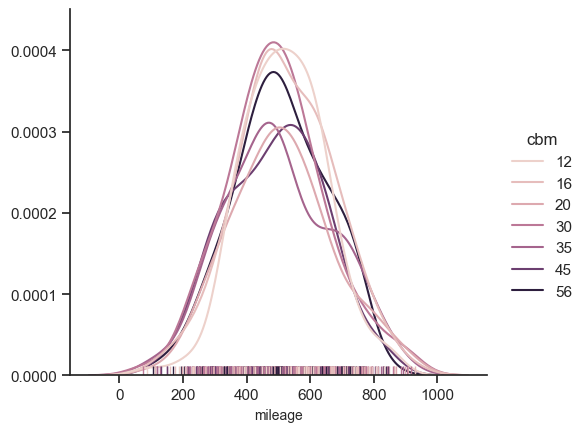

In [12]:
sns.set_theme(style="ticks")
ax = sns.displot(
    data = df, x='mile', hue='cbm', kind="kde", 
    rug=True, height=4.5, aspect=1.2)
ax.set_axis_labels('mileage', '', fontsize=10)
print('Kurtosis: %f' % df['mile'].kurt())
print('Skewness: %f' % df['mile'].skew())
plt.show()
#sns.despine(trim=True, left=True)

*calculate quantiles for a probability plot, and optionally show the plot.*

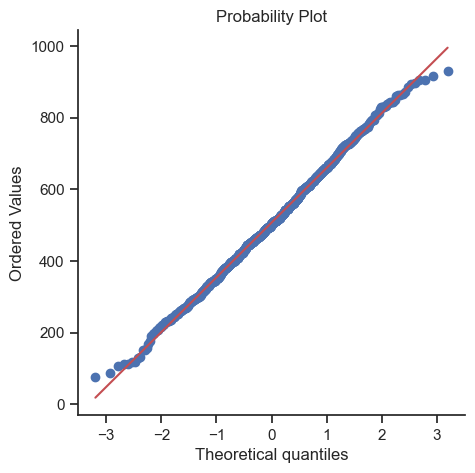

In [13]:
fig = plt.figure(figsize=(5, 5))
params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=params)
res = sp.stats.probplot(df['mile'], plot=plt)
plt.show()

### *Exploratory Data Analysis with Data Visualization*

*visualize the relationship between CBM and total cost*

<Axes: xlabel='cbm', ylabel='to_co'>

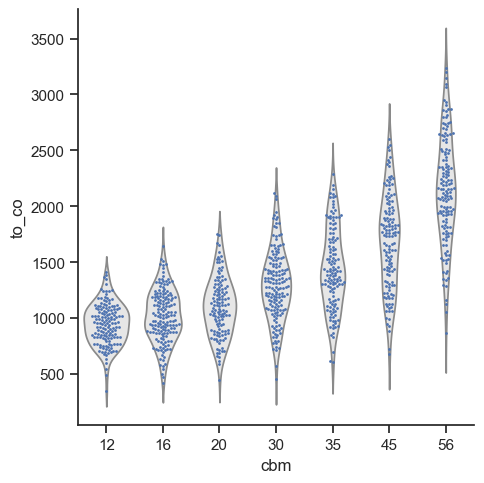

In [14]:
sns.catplot(data = df, x="cbm", y="to_co", kind="violin", color=".9", inner=None, aspect = 1)
sns.swarmplot(data=df, x="cbm", y="to_co", size=2)

### *Multiple Linear Regression*

*select some features used for regression.*

In [15]:
cdf = df
cdf.head()

,prov,mile,cbm,di_co,ro_to,sala,insu,ma_co,ty_co,prof,to_co
0,重庆,263,45,428.16,173.58,156.67,38.89,15.78,31.56,215.28,1059.92
1,广东,449,16,461.39,107.76,183.33,19.44,22.45,18.86,98.48,911.71
2,贵州,300,56,557.25,324.00,156.67,47.22,24.00,52.80,354.86,1516.80
3,黑龙江,445,12,415.36,89.00,183.33,19.44,22.25,18.69,90.91,838.98
4,广西,848,16,877.34,203.52,208.33,19.44,42.40,35.62,120.37,1507.02


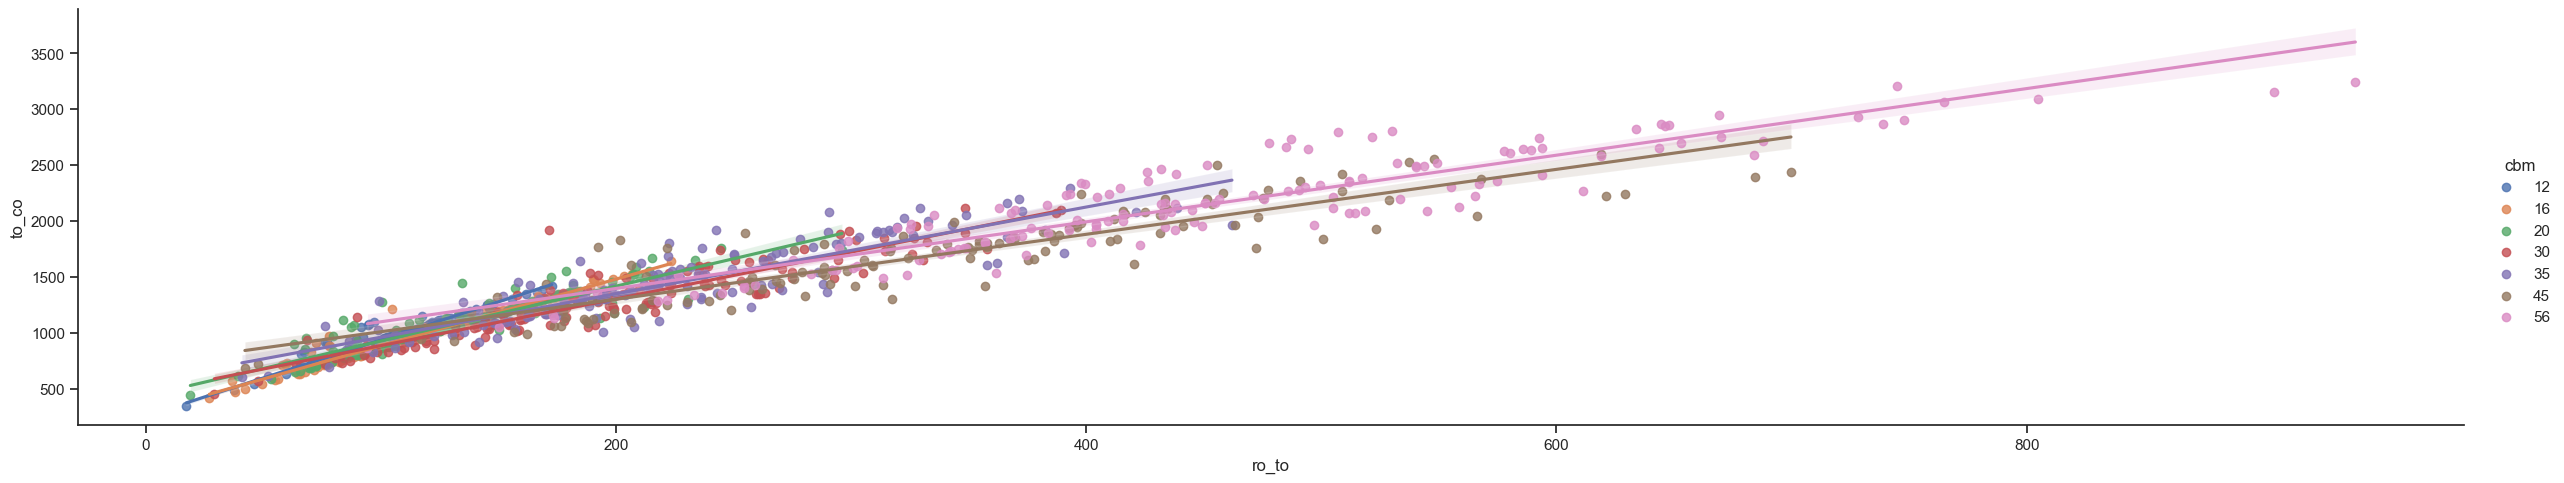

In [16]:
sns.lmplot(data = cdf,x="ro_to", y="to_co", hue=str("cbm"),aspect = 5)

*creating train and test dataset*

*用mask随机选择rows,80%训练，20%测试*

In [17]:
msk = np.random.rand(len(df)) < 0.8
train = cdf[msk]
test = cdf[~msk]

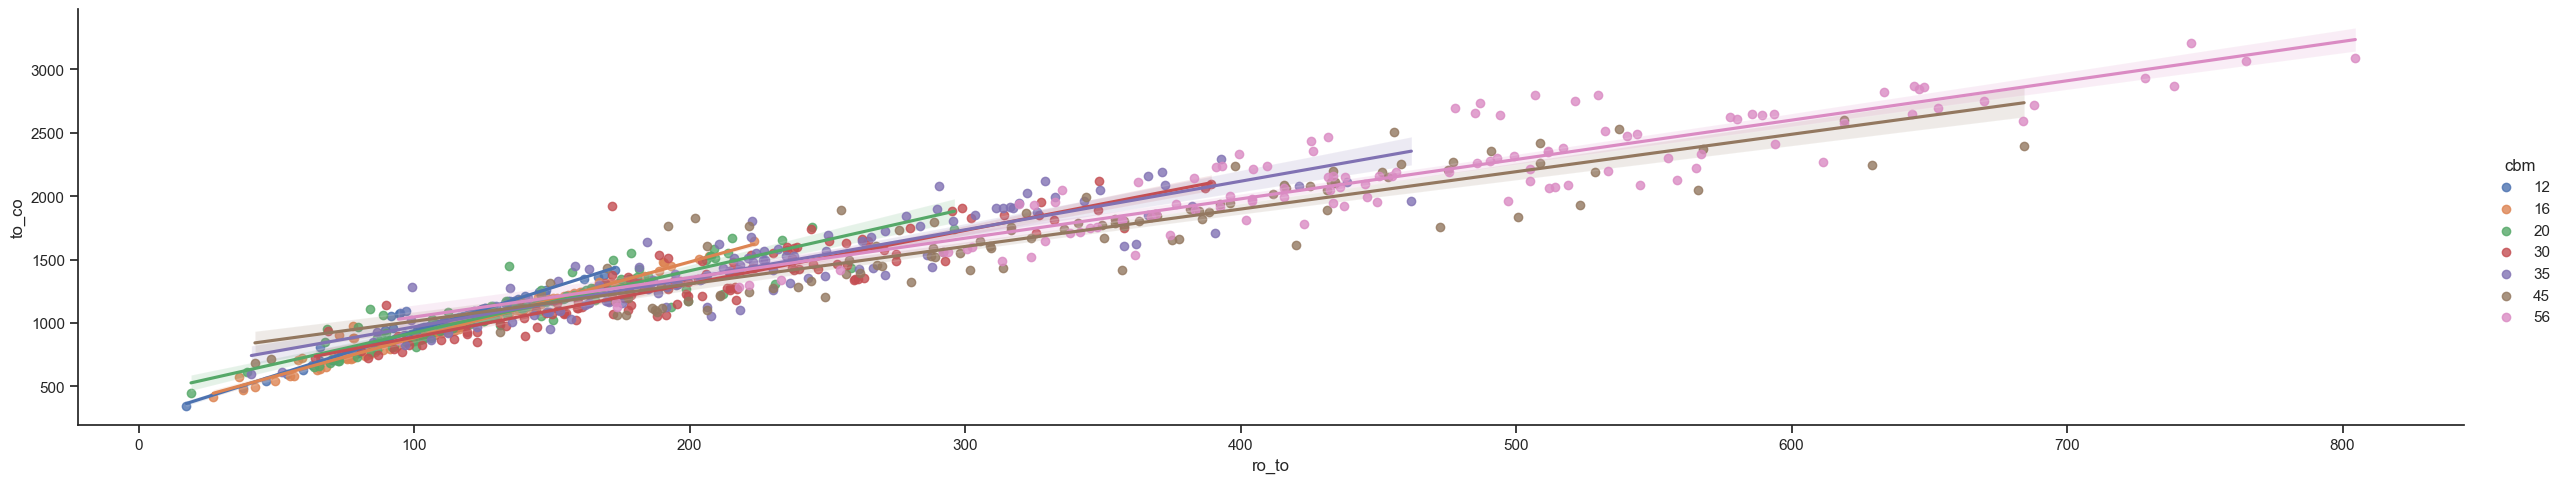

In [18]:
sns.lmplot(data = train,x="ro_to", y="to_co", hue=str("cbm"),aspect = 5)

*Modeling*

In [19]:
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['mile','cbm']])
train_y = np.asanyarray(train[['to_co']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [[ 2.06488159 27.3330765 ]]


*evaluating*

In [20]:
test_x = np.asanyarray(test[['mile','cbm']])
test_y = np.asanyarray(test[['to_co']])
test_y_hat = regr.predict(test_x)

print("Residual sum of squares (RSS): %.2f"
      % np.mean((test_y_hat - test_y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(test_x, test_y))

Residual sum of squares (RSS): 16955.85
Variance score: 0.94
